In [116]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import calendar
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


In [117]:
df = pd.read_csv("fraud.csv")


In [118]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [119]:
df.shape

(6362620, 11)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [121]:
df.duplicated().sum()

np.int64(0)

In [122]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [123]:
df.groupby(['type', 'isFraud']).size().unstack(fill_value=0)

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


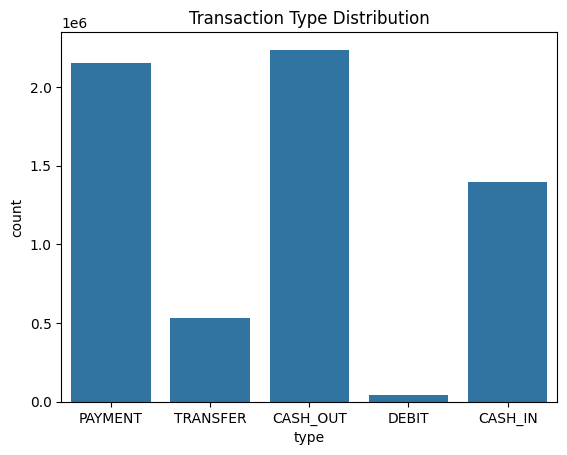

In [124]:
#Transaction Type Distribution

sns.countplot(x='type', data=df)
plt.title('Transaction Type Distribution')
plt.show()

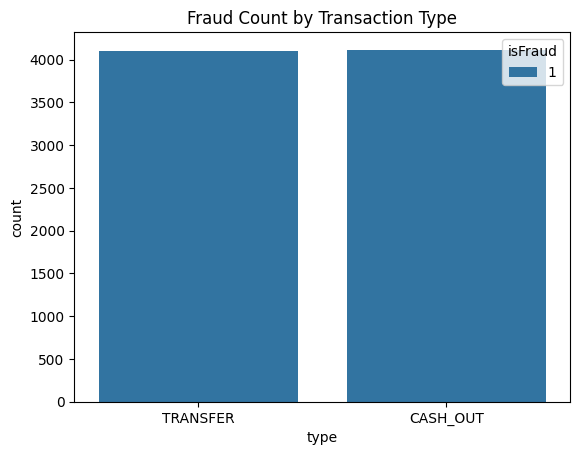

In [ ]:
# Transaction Type vs Fraud

sns.countplot(x='type', hue='isFraud', data=df[df["isFraud"] == 1])
plt.title('Fraud Count by Transaction Type')
plt.show()



In [ ]:
# Dividing amount into bins
bins = [0, 1000, 10000, 75000, 200000, 1_000_000, float('inf')]
labels = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large', 'Extreme']

df['amount_class'] = pd.cut(df['amount'], bins=bins, labels=labels, include_lowest=True)


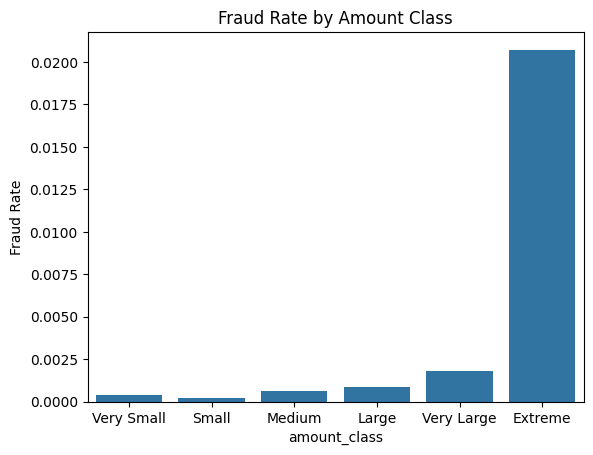

In [ ]:
#fraud rate by class of amount
fraud_rate = df.groupby('amount_class')['isFraud'].mean().reset_index()
sns.barplot(x='amount_class', y='isFraud', data=fraud_rate)
plt.title('Fraud Rate by Amount Class')
plt.ylabel('Fraud Rate')
plt.show()


<Axes: xlabel='log_amount', ylabel='Count'>

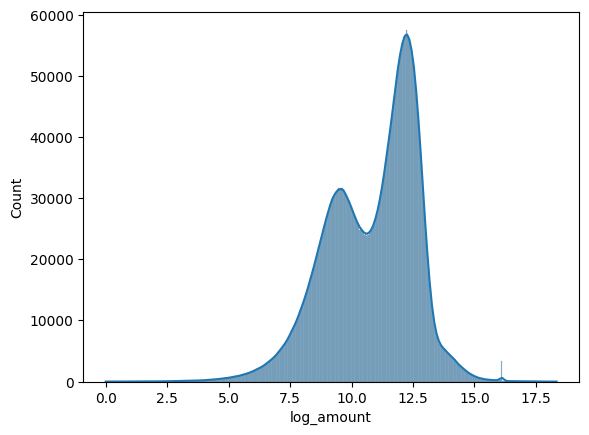

In [ ]:
# amount distribution
df['log_amount'] = np.log1p(df['amount'])
sns.histplot(df['log_amount'], kde=True)


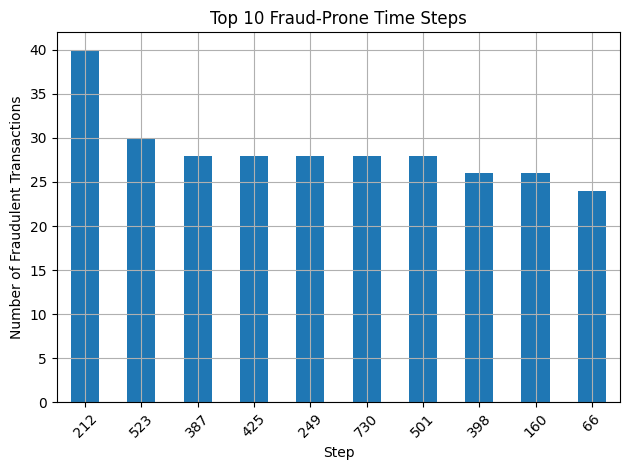

In [129]:
# Filter fraud transactions
fraud_only = df[df['isFraud'] == 1]

# Count frauds per step
fraud_by_step = fraud_only.groupby('step')['isFraud'].count()

# Get top 10 steps with most frauds
top_steps = fraud_by_step.sort_values(ascending=False).head(10)

# Plot
top_steps.plot(kind='bar')
plt.title('Top 10 Fraud-Prone Time Steps')
plt.xlabel('Step')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [130]:
df['nameDestType'] = df['nameDest'].apply(lambda x: 'merchant' if x.startswith('M') else 'customer')

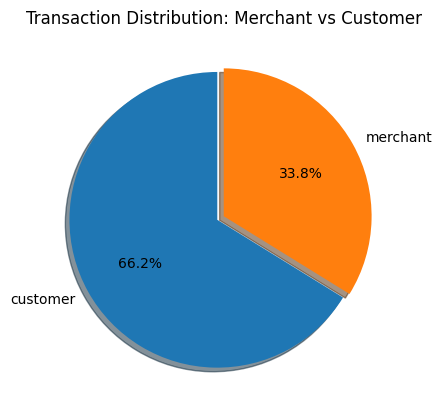

In [131]:
df['nameDestType'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', startangle=90, explode=[0.05, 0], shadow=True
)
plt.title('Transaction Distribution: Merchant vs Customer')
plt.ylabel('')  # Hide y-axis label
plt.show()


In [132]:
df.loc[df['nameDestType'] == 'merchant', ['oldbalanceDest', 'newbalanceDest']] = np.nan

In [133]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_class,log_amount,nameDestType
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,NaN,NaN,0,0,Small,9.194276,merchant
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,NaN,NaN,0,0,Small,7.531166,merchant
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,Very Small,5.204007,customer
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,Very Small,5.204007,customer
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,NaN,NaN,0,0,Medium,9.364703,merchant


In [134]:
df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']

In [135]:
df['dest_gap_vs_amount'] = df['dest_balance_change'] - df['amount']


In [136]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_class,log_amount,nameDestType,dest_balance_change,dest_gap_vs_amount
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,NaN,NaN,0,0,Small,9.194276,merchant,NaN,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,NaN,NaN,0,0,Small,7.531166,merchant,NaN,NaN
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,Very Small,5.204007,customer,0.0,-181.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,Very Small,5.204007,customer,-21182.0,-21363.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,NaN,NaN,0,0,Medium,9.364703,merchant,NaN,NaN


In [137]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [138]:
df['origin_balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['origin_gap_vs_amount'] = df['origin_balance_change'] - df['amount']

In [139]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_class,log_amount,nameDestType,dest_balance_change,dest_gap_vs_amount,origin_balance_change,origin_gap_vs_amount
0,1,PAYMENT,9839.64,170136.0,160296.36,NaN,NaN,0,0,Small,9.194276,merchant,NaN,NaN,9839.64,1.455192e-11
1,1,PAYMENT,1864.28,21249.0,19384.72,NaN,NaN,0,0,Small,7.531166,merchant,NaN,NaN,1864.28,-1.136868e-12
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,Very Small,5.204007,customer,0.0,-181.0,181.00,0.000000e+00
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,Very Small,5.204007,customer,-21182.0,-21363.0,181.00,0.000000e+00
4,1,PAYMENT,11668.14,41554.0,29885.86,NaN,NaN,0,0,Medium,9.364703,merchant,NaN,NaN,11668.14,0.000000e+00


In [140]:
df = pd.get_dummies(df, columns=['type','nameDestType'], drop_first=True)

In [141]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df['amount_class_encoded'] = encoder.fit_transform(df[['amount_class']])

df = df.drop(columns='amount_class')


In [142]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,log_amount,dest_balance_change,dest_gap_vs_amount,origin_balance_change,origin_gap_vs_amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameDestType_merchant,amount_class_encoded
0,1,9839.64,170136.0,160296.36,NaN,NaN,0,0,9.194276,NaN,NaN,9839.64,1.455192e-11,False,False,True,False,True,3.0
1,1,1864.28,21249.0,19384.72,NaN,NaN,0,0,7.531166,NaN,NaN,1864.28,-1.136868e-12,False,False,True,False,True,3.0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,5.204007,0.0,-181.0,181.00,0.000000e+00,False,False,False,True,False,5.0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,5.204007,-21182.0,-21363.0,181.00,0.000000e+00,True,False,False,False,False,5.0
4,1,11668.14,41554.0,29885.86,NaN,NaN,0,0,9.364703,NaN,NaN,11668.14,0.000000e+00,False,False,True,False,True,2.0


In [143]:
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)


In [144]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,log_amount,dest_balance_change,dest_gap_vs_amount,origin_balance_change,origin_gap_vs_amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameDestType_merchant,amount_class_encoded
0,1,9839.64,170136.0,160296.36,NaN,NaN,0,0,9.194276,NaN,NaN,9839.64,1.455192e-11,0,0,1,0,1,3.0
1,1,1864.28,21249.0,19384.72,NaN,NaN,0,0,7.531166,NaN,NaN,1864.28,-1.136868e-12,0,0,1,0,1,3.0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,5.204007,0.0,-181.0,181.00,0.000000e+00,0,0,0,1,0,5.0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,5.204007,-21182.0,-21363.0,181.00,0.000000e+00,1,0,0,0,0,5.0
4,1,11668.14,41554.0,29885.86,NaN,NaN,0,0,9.364703,NaN,NaN,11668.14,0.000000e+00,0,0,1,0,1,2.0


In [145]:
df['full_transfer_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1e-6)


In [146]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,log_amount,dest_balance_change,dest_gap_vs_amount,origin_balance_change,origin_gap_vs_amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameDestType_merchant,amount_class_encoded,full_transfer_ratio
0,1,9839.64,170136.0,160296.36,NaN,NaN,0,0,9.194276,NaN,NaN,9839.64,1.455192e-11,0,0,1,0,1,3.0,0.057834
1,1,1864.28,21249.0,19384.72,NaN,NaN,0,0,7.531166,NaN,NaN,1864.28,-1.136868e-12,0,0,1,0,1,3.0,0.087735
2,1,181.00,181.0,0.00,0.0,0.0,1,0,5.204007,0.0,-181.0,181.00,0.000000e+00,0,0,0,1,0,5.0,1.000000
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,5.204007,-21182.0,-21363.0,181.00,0.000000e+00,1,0,0,0,0,5.0,1.000000
4,1,11668.14,41554.0,29885.86,NaN,NaN,0,0,9.364703,NaN,NaN,11668.14,0.000000e+00,0,0,1,0,1,2.0,0.280795


In [147]:
df['dest_balance_change'] = df['dest_balance_change'].fillna(0)
df['dest_gap_vs_amount'] = df['dest_gap_vs_amount'].fillna(0)

In [148]:
df = df.drop(['newbalanceOrig','oldbalanceOrg','oldbalanceDest','newbalanceDest','log_amount','isFlaggedFraud',], axis=1)

In [149]:
df.isnull().sum()


step                     0
amount                   0
isFraud                  0
dest_balance_change      0
dest_gap_vs_amount       0
origin_balance_change    0
origin_gap_vs_amount     0
type_CASH_OUT            0
type_DEBIT               0
type_PAYMENT             0
type_TRANSFER            0
nameDestType_merchant    0
amount_class_encoded     0
full_transfer_ratio      0
dtype: int64

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   step                   int64  
 1   amount                 float64
 2   isFraud                int64  
 3   dest_balance_change    float64
 4   dest_gap_vs_amount     float64
 5   origin_balance_change  float64
 6   origin_gap_vs_amount   float64
 7   type_CASH_OUT          int64  
 8   type_DEBIT             int64  
 9   type_PAYMENT           int64  
 10  type_TRANSFER          int64  
 11  nameDestType_merchant  int64  
 12  amount_class_encoded   float64
 13  full_transfer_ratio    float64
dtypes: float64(7), int64(7)
memory usage: 679.6 MB


In [151]:
df.head()

,step,amount,isFraud,dest_balance_change,dest_gap_vs_amount,origin_balance_change,origin_gap_vs_amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameDestType_merchant,amount_class_encoded,full_transfer_ratio
0,1,9839.64,0,0.0,0.0,9839.64,1.455192e-11,0,0,1,0,1,3.0,0.057834
1,1,1864.28,0,0.0,0.0,1864.28,-1.136868e-12,0,0,1,0,1,3.0,0.087735
2,1,181.00,1,0.0,-181.0,181.00,0.000000e+00,0,0,0,1,0,5.0,1.000000
3,1,181.00,1,-21182.0,-21363.0,181.00,0.000000e+00,1,0,0,0,0,5.0,1.000000
4,1,11668.14,0,0.0,0.0,11668.14,0.000000e+00,0,0,1,0,1,2.0,0.280795


/Users/princegill/Documents/VSCode/assignment 1/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:27:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Classification Threshold: 0.5

 Confusion Matrix:
[[1270488     393]
 [     61    1582]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.80      0.96      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.90      0.98      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

 F1 Score: 0.8745
ROC AUC Score: 0.9997


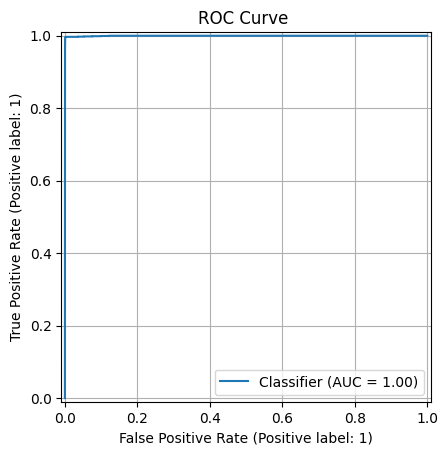

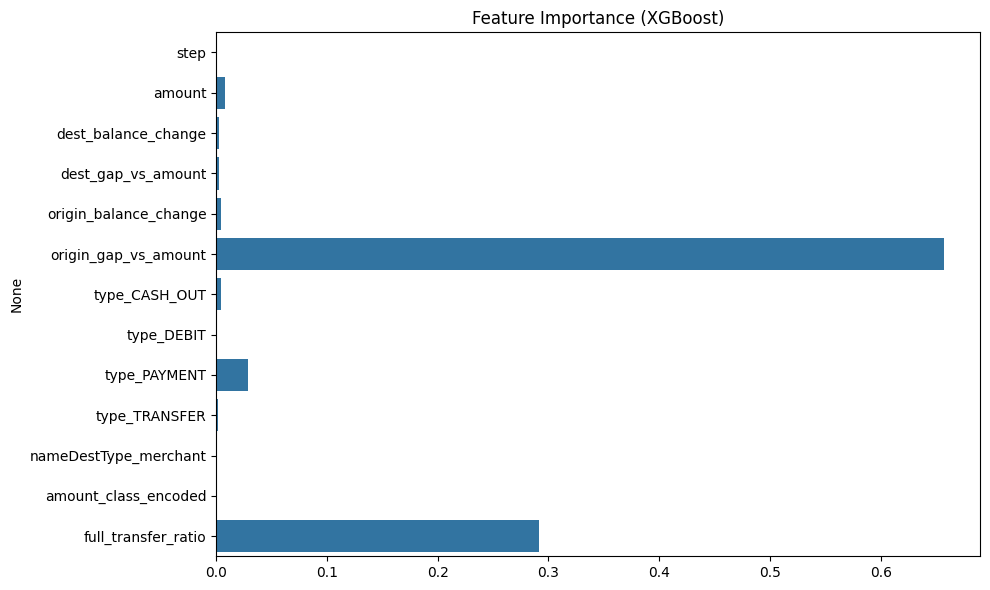

In [152]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    RocCurveDisplay
)


X = df.drop("isFraud", axis=1)
y = df["isFraud"]
X = X.fillna(0)  # Ensure no NaNs


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


model = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=8,
    n_estimators=200,
    subsample=0.8,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)


y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)  

custom_threshold = 0.5
y_pred_custom = (y_prob >= custom_threshold).astype(int)


print(f"\n Classification Threshold: {custom_threshold}")
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom))

print(f" F1 Score: {f1_score(y_test, y_pred_custom):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")



RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve ")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
importances = model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


1. Data Cleaning (Missing Values, Outliers, Multicollinearity)
Missing values: Initially, there weren’t any missing values. But later, we intentionally created missing values by assigning NaN to merchant-related balance fields. These were handled using .fillna(0) before modeling.
Outliers: Instead of removing them, we binned transaction amounts into meaningful categories (like "Small", "Extreme") to reduce their impact.
Multicollinearity: Redundant or highly correlated features (like both original and new balances) were removed to simplify the model and reduce noise.
2. Fraud Detection Model – What’s It Like?
We used XGBoost, a powerful gradient boosting model that's great for structured data and imbalanced problems (like fraud detection). The model was fine-tuned using:

Higher tree depth (max_depth=8) for better learning
Imbalance handling using scale_pos_weight
200 estimators and 0.2 learning rate
It's fast, accurate, and handles large datasets like this very well.

3. How Were Variables Selected?
We included:

Original transaction features (amount, type, balances)
Engineered features like:
full_transfer_ratio (how much of the sender’s balance was used)
origin_gap_vs_amount, dest_gap_vs_amount (to detect balance inconsistencies)
Categorical encodings for transaction type and destination type (customer/merchant)
We dropped IDs, redundant balances, and non-contributing fields like isFlaggedFraud.
Basically, we picked what made sense logically and statistically, and excluded the rest.

4. Model Performance – How Did It Do?
F1 Score and ROC AUC were used to evaluate the model.
Confusion matrix and classification report showed good fraud recall.
ROC curve proved it could separate frauds from legit transactions well.
Feature importance showed which inputs the model relied on most.
Overall, it did a solid job in detecting fraud despite the class imbalance.

5. What Key Factors Predict Fraud?
Transaction Type: Most frauds were in TRANSFER or CASH_OUT.
Balance Changes: Weird gaps between amount and balance changes were red flags.
Full Transfer Ratio: Fraudsters often try to withdraw entire balances.
These all came up as top features in the model’s importance scores.

6. Do These Factors Make Sense?
Yes, 100%. Here’s why:

Fraudsters often do complete cash-outs to empty accounts.
Suspicious gaps in balance movement can indicate tampering or trickery.
Specific transaction types like TRANSFER are common fraud channels in digital platforms.
So yeah, the model’s top features actually reflect real-world fraud behavior.

7. What Should the Company Do to Prevent Fraud?
Here are a few smart steps:

Real-time monitoring of high-value transfers.
Flags or holds for full balance withdrawals or large merchant transfers.
User behavior profiling (like step-based patterns).
Limit exposure by locking suspicious accounts or introducing cooldowns.
Improve KYC and transaction validation especially for merchant accounts.
Also, deploying this model in production would help flag frauds instantly.

8. How Would You Know If Prevention Works?
After rolling out preventive measures:

Monitor fraud rates over time (they should go down).
Compare model predictions with actual confirmed fraud cases.
Watch for drop in high-risk transactions.
Conduct regular model retraining and performance audits.
Basically, if fraud numbers drop and fewer false alarms happen, it’s working.

